In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from torch.utils.data import DataLoader

In [3]:
%load_ext autoreload
%autoreload 2

from utility.data_processing import create_data
from utility.model import pinball_loss, QuantileTimeSeriesNN, CryptoDataset, conformal_score

In [4]:
df = pd.read_csv('./data/btc_metrics_5_years.csv')

In [5]:
X_train, X_test, y_train, y_test = create_data(df)

In [6]:
X_train

tensor([[ 3.9685e-03,  6.5789e-01],
        [ 3.0885e-04,  4.1002e-02],
        [ 5.4961e-02, -5.7913e-01],
        ...,
        [ 4.2913e-03,  4.1783e-01],
        [-1.9698e-04, -8.0061e-02],
        [ 4.1687e-02,  3.0800e-01]])

In [7]:
train_dataset = CryptoDataset(X_train, y_train)
test_dataset = CryptoDataset(X_test, y_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=124, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [9]:
import torch.optim as optim

In [10]:
# Training loop
models = {}
for quantile in [0.05, 0.95]:

    model = QuantileTimeSeriesNN(input_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    num_epochs = 500
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = pinball_loss(y_pred, y_batch.view(-1, 1), quantile)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Quantile {quantile}, Loss: {total_loss / len(train_loader)}")
    models[f'model_{int(quantile*100)}'] = model

Epoch 0, Quantile 0.05, Loss: 0.010753518824155131
Epoch 100, Quantile 0.05, Loss: 0.0004920141800539568
Epoch 200, Quantile 0.05, Loss: 0.00021827280943398364
Epoch 300, Quantile 0.05, Loss: 0.00031572272200719453
Epoch 400, Quantile 0.05, Loss: 0.00024215983527634913
Epoch 0, Quantile 0.95, Loss: 0.00531700001253436
Epoch 100, Quantile 0.95, Loss: 0.0004979361207612479
Epoch 200, Quantile 0.95, Loss: 0.0006527579268246578
Epoch 300, Quantile 0.95, Loss: 0.00048575822681110975
Epoch 400, Quantile 0.95, Loss: 0.000520206815660155


In [11]:
for X_test, y_test in test_loader:
    break

In [12]:
alpha = 0.05
a = (1 - alpha)*(1 + 1 / len(y_test))

In [13]:
a

0.9526027397260275

In [14]:
y_95 = models['model_95'](X_test)
y_5 = models['model_5'](X_test)

In [15]:
score = conformal_score(y_5, y_95, y_test)

In [16]:
Q = torch.quantile(score, a).item()

In [17]:
low_bound = (y_5 - Q).detach().numpy()
upper_bound = (y_95 + Q).detach().numpy()
real_return = y_test.detach().numpy()

In [18]:
# low_cum_return = np.exp((np.cumsum(low_bound))) - 1
# upper_cum_return = np.exp((np.cumsum(upper_bound))) - 1
# real_cum_return = np.exp((np.cumsum(real_return))) - 1

In [19]:
time_steps = np.arange(1, len(real_return)+1)

In [20]:
# Create DataFrame for Seaborn
df = pd.DataFrame({
    "Time": time_steps,
    "Real Return": real_return.reshape(-1),
    "Lower Bound": low_bound.reshape(-1),
    "Upper Bound": upper_bound.reshape(-1)
})

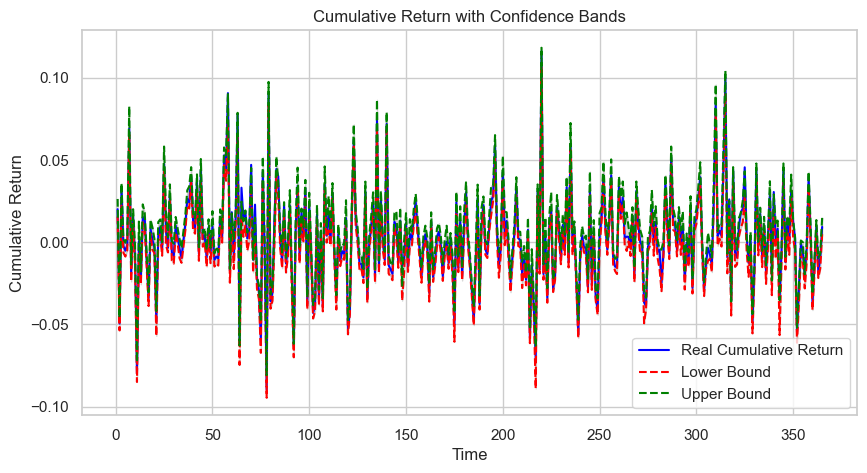

In [21]:
# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

sns.lineplot(x="Time", y="Real Return", data=df, label="Real Cumulative Return", color="blue")
sns.lineplot(x="Time", y="Lower Bound", data=df, label="Lower Bound", color="red", linestyle="dashed")
sns.lineplot(x="Time", y="Upper Bound", data=df, label="Upper Bound", color="green", linestyle="dashed")

# Fill confidence band
plt.fill_between(df["Time"], df["Lower Bound"], df["Upper Bound"], color="gray", alpha=0.3)

# Labels and title
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return with Confidence Bands")
plt.legend()
plt.show()

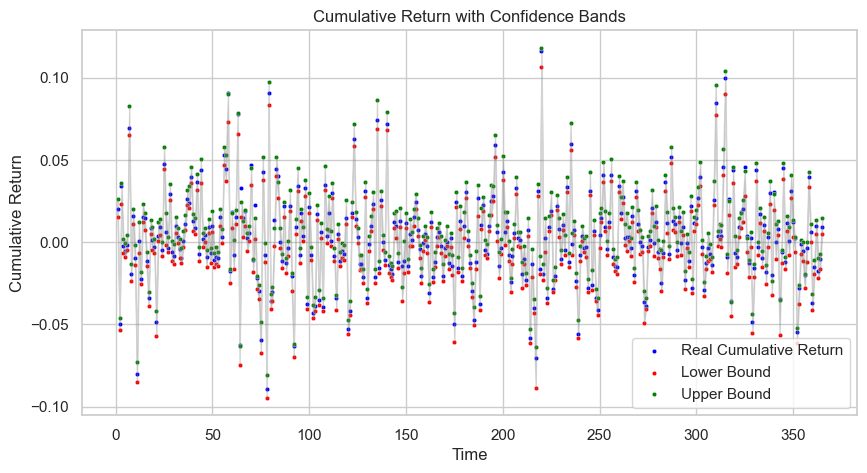

In [22]:
# Plot using Seaborn
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")

sns.scatterplot(x="Time", y="Real Return", data=df, label="Real Cumulative Return", color="blue", s=10)
sns.scatterplot(x="Time", y="Lower Bound", data=df, label="Lower Bound", color="red", s=10)
sns.scatterplot(x="Time", y="Upper Bound", data=df, label="Upper Bound", color="green", s=10)

# Fill confidence band
plt.fill_between(df["Time"], df["Lower Bound"], df["Upper Bound"], color="gray", alpha=0.3)

# Labels and title
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return with Confidence Bands")
plt.legend()
plt.show()

In [23]:
df[df['Real Return'] < df['Lower Bound']]

,Time,Real Return,Lower Bound,Upper Bound


In [24]:
df[df['Real Return'] > df['Upper Bound']]

,Time,Real Return,Lower Bound,Upper Bound
57,58,0.090612,0.073067,0.090049
59,60,0.018232,0.008775,0.017514
63,64,-0.062748,-0.074605,-0.062798
64,65,0.033115,0.015516,0.024673
65,66,0.014517,0.003295,0.012729
69,70,0.047015,0.035001,0.045168
71,72,0.022820,0.002181,0.014951
81,82,0.013685,-0.002098,0.008906
83,84,0.040090,0.026869,0.036410
147,148,-0.014598,-0.035508,-0.027078


In [25]:
len(real_return)

365